In [1]:
import sys
sys.path.append("..")

from causal.causal_model import CausalModel
import random
OBJECT_COLORS = [("banana", "yellow"), ("grass", "green"), ("strawberry", "red"), ("coconut", "brown"), ("eggplant", "purple"),
                 ("blueberry", "blue"), ("carrot", "orange"), ("coal", "black"), ("snow", "white"), ("ivory", "white"), ("cauliflower", "white"),
                 ("bubblegum", "pink"), ("lemon", "yellow"), ("lime", "green"), ("ruby", "red"), ("chocolate", "brown"), ("emerald", "green"), 
                 ("sapphire", "blue"), ("pumpkin", "orange")]
OBJECTS, COLORS= zip(*OBJECT_COLORS)
COLORS = list(set(COLORS))  # Ensure unique colors

NUM_CHOICES = 2
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TEMPLATES = ["The <object> is <color>. What color is the <object>?" + "".join([f"\n<symbol{str(i)}>. <choice{str(i)}>" for i in range(NUM_CHOICES)]) + "\nAnswer:"]

variables = ["template", "object_color", "raw_input"] + ["symbol" + str(x) for x in range(NUM_CHOICES)] + ["choice" + str(x) for x in range(NUM_CHOICES)] + ["answer_position", "answer", "raw_output"]

values = {"choice" + str(x): COLORS for x in range(NUM_CHOICES)}
values.update({"symbol" + str(x): ALPHABET for x in range(NUM_CHOICES)})
values.update({"answer_position": range(NUM_CHOICES), "answer": ALPHABET})
values.update({"template": TEMPLATES})
values.update({"object_color": OBJECT_COLORS})
values.update({"raw_input": None, "raw_output": None})

parents = {
        "template": [],
        "object_color": [],
        "raw_input": ["template", "object_color"] + ["symbol" + str(x) for x in range(NUM_CHOICES)] + ["choice" + str(x) for x in range(NUM_CHOICES)],
        "answer_position": ["object_color"] + ["choice" + str(x) for x in range(NUM_CHOICES)],
        "answer": ["answer_position"] + ["symbol" + str(x) for x in range(NUM_CHOICES)], 
        "raw_output": ["answer"],
        }
parents.update({"choice" + str(x): [] for x in range(NUM_CHOICES)})
parents.update({"symbol" + str(x): [] for x in range(NUM_CHOICES)})

def fill_template(*args):
    template, object_color = args[0], args[1]
    symbols = args[2:2 + NUM_CHOICES]
    choices = args[2 + NUM_CHOICES:2 + 2 * NUM_CHOICES]

    object_name, color = object_color
    filled_template = template.replace("<object>", object_name).replace("<color>", color)
    for i, symbol in enumerate(symbols):
        filled_template = filled_template.replace(f"<symbol{i}>", symbol)
    for i, choice in enumerate(choices):
        filled_template = filled_template.replace(f"<choice{i}>", choice)
    return filled_template

def get_answer_position(object_color, *choices):
    for i, choice in enumerate(choices):
        if choice == object_color[1]:
            return i

def get_answer(answer_position, *symbols):
    if answer_position is None:
        return None
    return symbols[answer_position]

mechanisms = {
    "template": lambda: random.choice(TEMPLATES),
    "object_color": lambda: random.choice(OBJECT_COLORS),
    **{f"symbol{i}": lambda: random.choice(ALPHABET) for i in range(NUM_CHOICES)},
    **{f"choice{i}": lambda: random.choice(COLORS) for i in range(NUM_CHOICES)},
    "raw_input": fill_template,
    "answer_position": get_answer_position,
    "answer": get_answer,
    "raw_output": lambda x: " " + x if x is not None else None,
}

MCQA_causal_model = CausalModel(variables, values, parents, mechanisms, id=f"{NUM_CHOICES}_answer_MCQA")

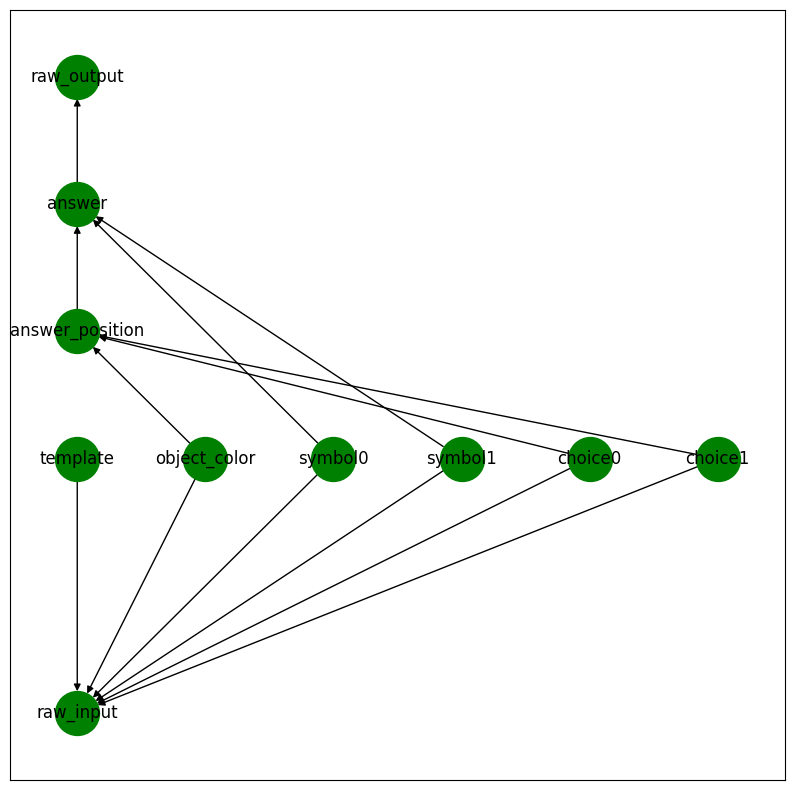

In [ ]:
MCQA_causal_model.print_structure()


Causal model inputs are dictionaries from variable names to values. Now we can write a sampler that generates questions that can be answered, i.e., the color of the object appears among the choices.

In [3]:
def sample_answerable_question():
    input = MCQA_causal_model.sample_input()
    #sample unique choices and symbols
    choices = random.sample(COLORS, NUM_CHOICES)
    symbols = random.sample(ALPHABET, NUM_CHOICES)
    for idx in range(NUM_CHOICES):
        input["choice" + str(idx)] = choices[idx]
        input["symbol" + str(idx)] = symbols[idx]
    if input["object_color"][1] not in [input["choice" + str(x)] for x in range(NUM_CHOICES)]:
        index = random.randint(0, NUM_CHOICES - 1)
        input["choice" + str(index)] = input["object_color"][1]
    return input

example = sample_answerable_question()
full_setting = MCQA_causal_model.run_forward(example)
print("Example input:")
for k, v in example.items():
    print(f"{k}: {v}\n")
print("\nFull setting determined by the causal model:")
for k, v in full_setting.items():
    if k not in example:
        print(f"{k}: {v}\n")


Example input:
template: The <object> is <color>. What color is the <object>?
<symbol0>. <choice0>
<symbol1>. <choice1>
Answer:

object_color: ('cauliflower', 'white')

symbol0: U

symbol1: N

choice0: yellow

choice1: white


Full setting determined by the causal model:
answer_position: 1

answer: N

raw_input: The cauliflower is white. What color is the cauliflower?
U. yellow
N. white
Answer:

raw_output:  N



# Loading in the language model

In [4]:
from neural.pipeline import LMPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
pipeline = LMPipeline(model_name, max_new_tokens=1, device=device, dtype=torch.float16, max_length=64)
pipeline.tokenizer.padding_side = "left"

def checker(neural_output, causal_output):
    return causal_output in neural_output or neural_output in causal_output

print("DEVICE:", pipeline.model.device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

DEVICE: cuda:0


# Single example causal tracing

In this experiment, we trace how the causal effect from a crucial input token flows to the output token. Namely, we focus on how the symbol token for the correct answer effects the output. We start by writing a function that samples an input and then generates the counterfactual where that the answer is in the same position, but the symbol for the correct answer has been replaced.


In [5]:
def different_symbol_same_position():
    input = sample_answerable_question()
    counterfactual = input.copy()
    full_setting = MCQA_causal_model.run_forward(input)

    current_symbols = [input["symbol" + str(i)] for i in range(NUM_CHOICES)]
    complement = [ x for x in ALPHABET if x not in current_symbols]
    new_symbol = random.choice(complement)
    i = full_setting["answer_position"]
    counterfactual["symbol" + str(i)] = new_symbol

    input["raw_input"] = full_setting["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

example = different_symbol_same_position()
print("\nExample input:")
print(f"input: {example['input']['raw_input']}")
print("\nCounterfactual example:")
print(f"input: {example['counterfactual_inputs'][0]['raw_input']}")


Example input:
input: The chocolate is brown. What color is the chocolate?
S. orange
V. brown
Answer:

Counterfactual example:
input: The chocolate is brown. What color is the chocolate?
S. orange
D. brown
Answer:


Check that the language model correctly answers the original and counterfactual inputs. Resample the input if an assertion error occurs.

In [6]:
input_example = example["input"]
counterfactual_example = example["counterfactual_inputs"][0]

# Check if the model gets both examples correct
print("\n" + "="*50)
print("Testing model predictions:")
print("="*50)

# Test original
original_pred = pipeline.dump(pipeline.generate(input_example["raw_input"]))
print(f"\nOriginal prediction: {original_pred}")
causal_output = MCQA_causal_model.run_forward(input_example)["raw_output"]
print(f"Causal output: {causal_output}")
assert checker(original_pred, causal_output), "Original prediction does not match causal output!"

# Test counterfactual
counterfactual_pred = pipeline.dump(pipeline.generate(counterfactual_example["raw_input"]))
print(f"\nCounterfactual prediction: {counterfactual_pred}")
causal_output = MCQA_causal_model.run_forward(counterfactual_example)["raw_output"]
print(f"Causal output: {causal_output}")
assert checker(counterfactual_pred, causal_output), "Counterfactual prediction does not match causal output!"



The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Testing model predictions:

Original prediction:  V
Causal output:  V

Counterfactual prediction:  D
Causal output:  D


## Visualizing the results interchange interventions for a single pair of inputs

We perform an interchange intervention on full vectors of the residual stream, i.e., the transformer block output, in the language model for every token position and every layer. After each intervention, we record the output of the language model. When an intervention results in the output the language model would have provided for the counterfactual input, we know that the signal from the token change is contained in that vector. 

In [7]:
# # Import the tracing experiment
# from experiments.residual_stream_experiment import SameLengthResidualStreamTracing

# # Run the tracing experiment
# print("\n" + "="*50)
# print("Running SameLengthResidualStreamTracing experiment...")
# print("="*50)

# # Create the tracing experiment
# tracing_exp = SameLengthResidualStreamTracing(
#     pipeline=pipeline,
#     causal_model=MCQA_causal_model,
#     checker=checker,
# )

# # Run the experiment with our counterfactual pair
# results = tracing_exp.run(
#     base_input=input_example,
#     counterfactual_input=counterfactual_example
# )

# print(f"\nTracing completed for {len(results)} layer-position combinations")

# Aggregating Interchange Intervention Experiments 

Using a single pair of examples is useful as an exploratory experiment, but rigorously supporting mechanistic interpretability hypotheses requires systematic evaluations of aggregated results from many experiments.

## Constructing Counterfactual Examples to Localize the Answer Position Variable

In [8]:
from causal.causal_model import CounterfactualDataset
dataset = CounterfactualDataset.from_sampler(100, different_symbol_same_position)
MCQA_causal_model.can_distinguish_with_dataset(dataset, ["answer_position"], ["answer"])
MCQA_causal_model.can_distinguish_with_dataset(dataset, ["answer_position"], None)

Can distinguish between ['answer_position'] and ['answer']: 100 out of 100 examples
Proportion of distinguishable examples: 1.00
Can distinguish between ['answer_position'] and None: 0 out of 100 examples
Proportion of distinguishable examples: 0.00


{'proportion': 0.0, 'count': 0}

In [9]:
from causal.causal_model import CounterfactualDataset

def same_symbol_different_position():
    input = sample_answerable_question()
    counterfactual = input.copy()

    pos = MCQA_causal_model.run_forward(input)["answer_position"]
    new_pos = random.choice([i for i in range(NUM_CHOICES) if i != pos])
    counterfactual["choice" + str(pos)] = input["choice" + str(new_pos)]
    counterfactual["choice" + str(new_pos)] = input["choice" + str(pos)]
    counterfactual["symbol" + str(pos)] = input["symbol" + str(new_pos)]
    counterfactual["symbol" + str(new_pos)] = input["symbol" + str(pos)]
    input["raw_input"] = MCQA_causal_model.run_forward(input)["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

def different_symbol_different_position():
    input = sample_answerable_question()
    counterfactual = input.copy()

    #Different position
    pos = MCQA_causal_model.run_forward(input)["answer_position"]
    new_pos = random.choice([i for i in range(NUM_CHOICES) if i != pos])
    counterfactual["choice" + str(pos)] = input["choice" + str(new_pos)]
    counterfactual["choice" + str(new_pos)] = input["choice" + str(pos)]

    #Different symbol
    current_symbols = [input["symbol" + str(i)] for i in range(NUM_CHOICES)]
    complement = [ x for x in ALPHABET if x not in current_symbols]
    new_symbols = random.sample(complement, NUM_CHOICES)
    for i in range(NUM_CHOICES):
        counterfactual["symbol" + str(i)] = new_symbols[i]

    input["raw_input"] = MCQA_causal_model.run_forward(input)["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

def random_counterfactual():
    input, counterfactual = sample_answerable_question(), sample_answerable_question()
    input["raw_input"] = MCQA_causal_model.run_forward(input)["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

counterfactual_datasets = { "same_symbol_different_position": CounterfactualDataset.from_sampler(100, same_symbol_different_position), 
                            "different_symbol_different_position": CounterfactualDataset.from_sampler(100, different_symbol_different_position), 
                            "different_symbol_same_position": CounterfactualDataset.from_sampler(100, different_symbol_same_position), 
                            "random_counterfactual": CounterfactualDataset.from_sampler(100, random_counterfactual) }


In [10]:
MCQA_causal_model.can_distinguish_with_dataset(counterfactual_datasets["same_symbol_different_position"], ["answer_position"], ["answer"])
MCQA_causal_model.can_distinguish_with_dataset(counterfactual_datasets["same_symbol_different_position"], ["answer_position"], None)

MCQA_causal_model.can_distinguish_with_dataset(counterfactual_datasets["random_counterfactual"], ["answer_position"], ["answer"])
MCQA_causal_model.can_distinguish_with_dataset(counterfactual_datasets["random_counterfactual"], ["answer_position"], None)

MCQA_causal_model.can_distinguish_with_dataset(counterfactual_datasets["different_symbol_different_position"], ["answer_position"], ["answer"])
MCQA_causal_model.can_distinguish_with_dataset(counterfactual_datasets["different_symbol_different_position"], ["answer_position"], None)

Can distinguish between ['answer_position'] and ['answer']: 100 out of 100 examples
Proportion of distinguishable examples: 1.00
Can distinguish between ['answer_position'] and None: 100 out of 100 examples
Proportion of distinguishable examples: 1.00
Can distinguish between ['answer_position'] and ['answer']: 95 out of 100 examples
Proportion of distinguishable examples: 0.95
Can distinguish between ['answer_position'] and None: 53 out of 100 examples
Proportion of distinguishable examples: 0.53
Can distinguish between ['answer_position'] and ['answer']: 100 out of 100 examples
Proportion of distinguishable examples: 1.00
Can distinguish between ['answer_position'] and None: 100 out of 100 examples
Proportion of distinguishable examples: 1.00


{'proportion': 1.0, 'count': 100}

## Filtering Out Examples the Language Model Answers Incorrectly

In [11]:
# Get a sample input and check model's prediction
sampled_example = next(iter(counterfactual_datasets.values()))[0]
print("INPUT:", sampled_example["input"])
print("EXPECTED OUTPUT:", MCQA_causal_model.run_forward(sampled_example["input"])["raw_output"])
print("MODEL PREDICTION:", pipeline.dump(pipeline.generate(sampled_example["input"])))

INPUT: {'choice0': 'pink', 'choice1': 'green', 'object_color': ['emerald', 'green'], 'raw_input': 'The emerald is green. What color is the emerald?\nX. pink\nJ. green\nAnswer:', 'symbol0': 'X', 'symbol1': 'J', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}
EXPECTED OUTPUT:  J
MODEL PREDICTION:  J


In [12]:
from experiments.filter_experiment import FilterExperiment
# Filter the datasets based on model performance
print("\nFiltering datasets based on model performance...")
exp = FilterExperiment(pipeline, MCQA_causal_model, checker)
filtered_datasets = exp.filter(counterfactual_datasets, verbose=True, batch_size=128)


Filtering datasets based on model performance...


Filtering same_symbol_different_position: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Dataset 'same_symbol_different_position': kept 98/100 examples (98.0%)


Filtering different_symbol_different_position: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Dataset 'different_symbol_different_position': kept 100/100 examples (100.0%)


Filtering different_symbol_same_position: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Dataset 'different_symbol_same_position': kept 97/100 examples (97.0%)


Filtering random_counterfactual: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Dataset 'random_counterfactual': kept 98/100 examples (98.0%)

Total filtering results:
Original examples: 400
Kept examples: 393
Overall keep rate: 98.2%


## Define token positions of interest

In [13]:
from neural.LM_units import TokenPosition, get_last_token_index
import re

def get_correct_symbol_index(input, pipeline, causal_model):
    """
    Find the index of the correct answer symbol in the prompt.
    
    Args:
        input (Dict): The input dictionary to a causal model
        pipeline: The tokenizer pipeline
        
    Returns:
        list[int]: List containing the index of the correct answer symbol token
    """
    # Run the model to get the answer position
    output = causal_model.run_forward(input)
    pos = output["answer_position"]
    correct_symbol = output[f"symbol{pos}"]
    prompt = input["raw_input"]
    
    # Find all single uppercase letters in the prompt
    matches = list(re.finditer(r"\b[A-Z]\b", prompt))
    
    # Find the match corresponding to our correct symbol
    symbol_match = None
    for match in matches:
        if prompt[match.start():match.end()] == correct_symbol:
            symbol_match = match
            break
            
    if not symbol_match:
        raise ValueError(f"Could not find correct symbol {correct_symbol} in prompt: {prompt}")
    
    # Get the substring up to the symbol match end
    substring = prompt[:symbol_match.end()]
    tokenized_substring = list(pipeline.load(substring, max_length=False)["input_ids"][0])
    tokenized_prompt = list(pipeline.load(prompt)["input_ids"][0])

    m = len(tokenized_substring)
    end_idx = next((i + m for i in range(len(tokenized_prompt) - m + 1)
                                    if tokenized_prompt[i:i+m] == tokenized_substring), -1)
    return [end_idx-1]

# Create TokenPosition object
token_positions = [
    TokenPosition(lambda x: get_correct_symbol_index(x, pipeline, MCQA_causal_model), pipeline, id="correct_symbol"),
    TokenPosition(lambda x: [get_correct_symbol_index(x, pipeline, MCQA_causal_model)[0]+1], pipeline, id="correct_symbol_period"),
    TokenPosition(lambda x: get_last_token_index(x, pipeline), pipeline, id="last_token")
]

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


We can use a method from the TokenPosition class to print out the token position selected for an example:   

In [14]:
for token_position in token_positions:
    print(f"\nToken position: {token_position.id}")
    example = next(iter(counterfactual_datasets.values()))[0]["input"]
    print(f"Selected token: {token_position.highlight_selected_token(example)}")
    



Token position: correct_symbol
Selected token: <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|>The emerald is green. What color is the emerald?
X. pink
**J**. green
Answer:

Token position: correct_symbol_period
Selected token: <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|

## Performing Interchange Interventions on the Residual Stream

In [15]:
from experiments.residual_stream_experiment import PatchResidualStream

start = 0
end = pipeline.get_num_layers()
config = {"batch_size":128}
target_variables_list  = [["answer"], ["answer_position"]]
results_dir = "MCQA_demo_results"



In [16]:
experiment = PatchResidualStream(pipeline, MCQA_causal_model, list(range(start, end)), token_positions, checker, config=config)
raw_results = experiment.perform_interventions(filtered_datasets, verbose=False, target_variables_list=target_variables_list, save_dir=results_dir)


Heatmaps for 'answer' variable:


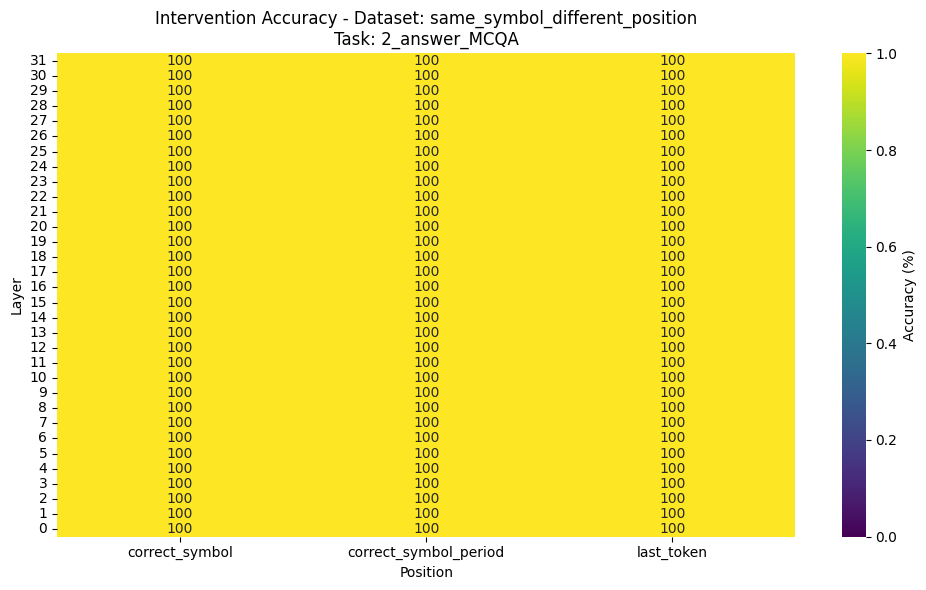

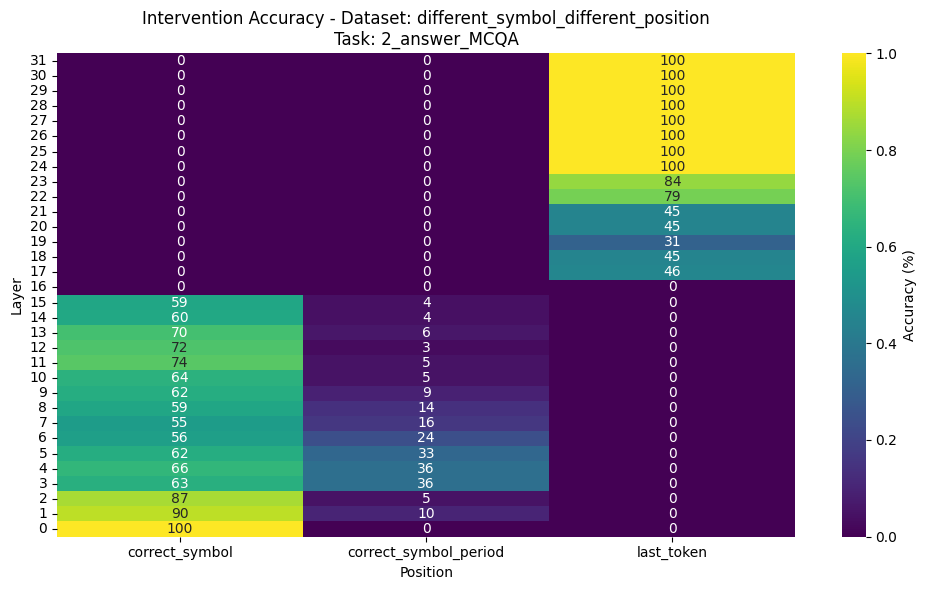

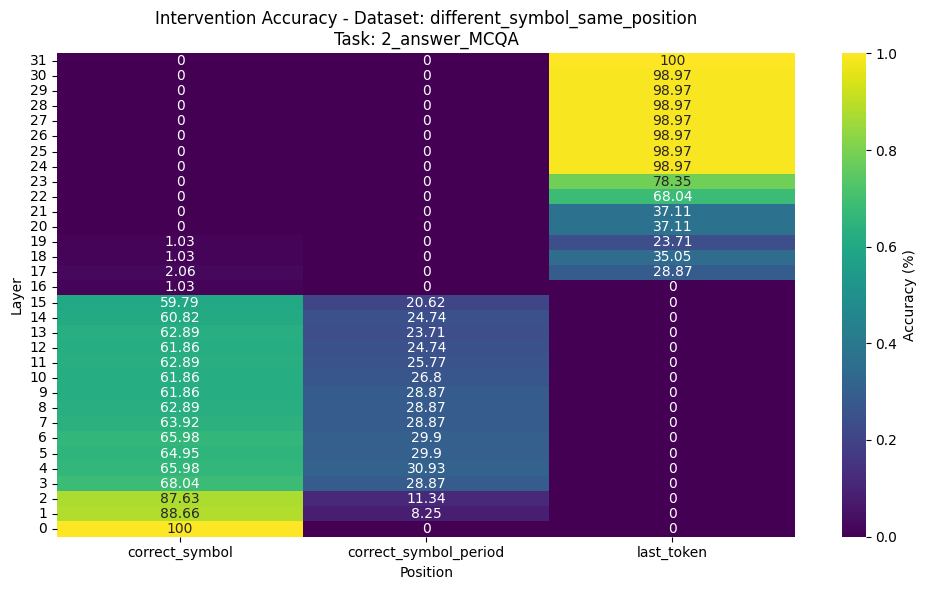

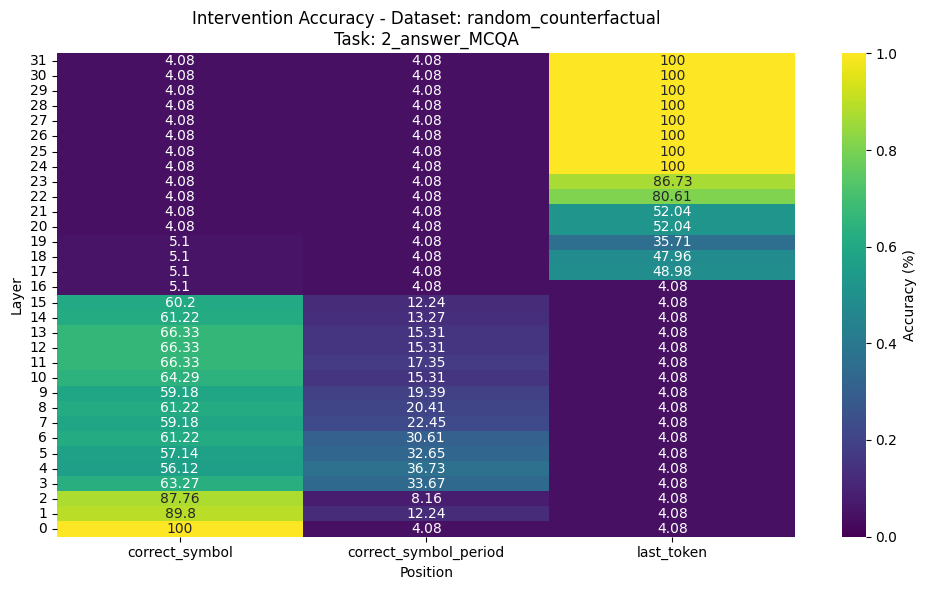


Heatmaps for 'answer_position' variable:


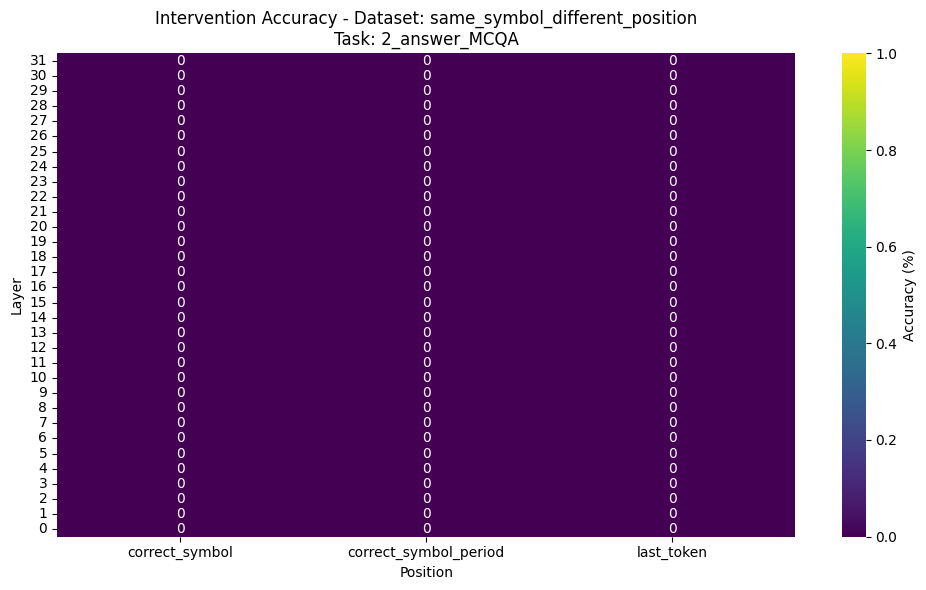

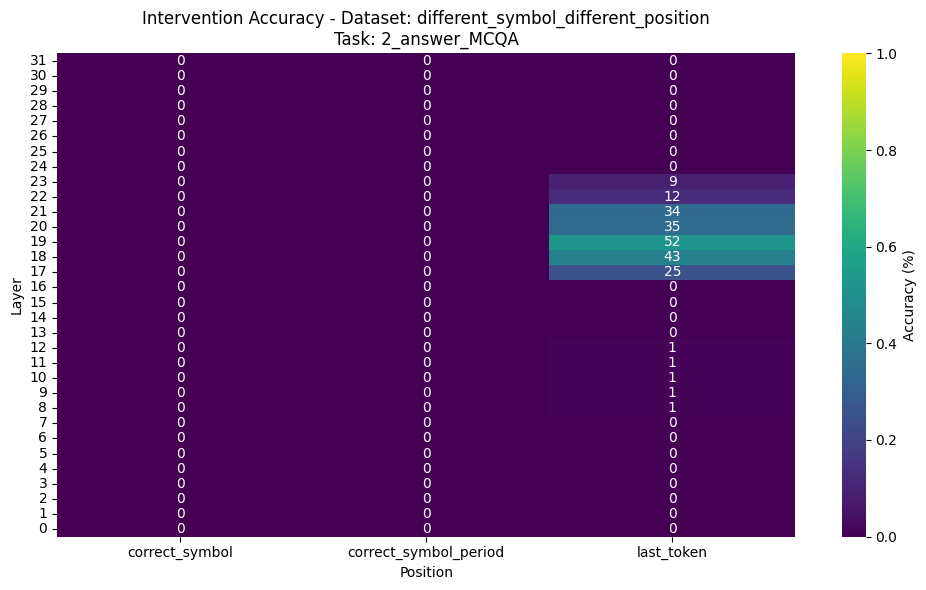

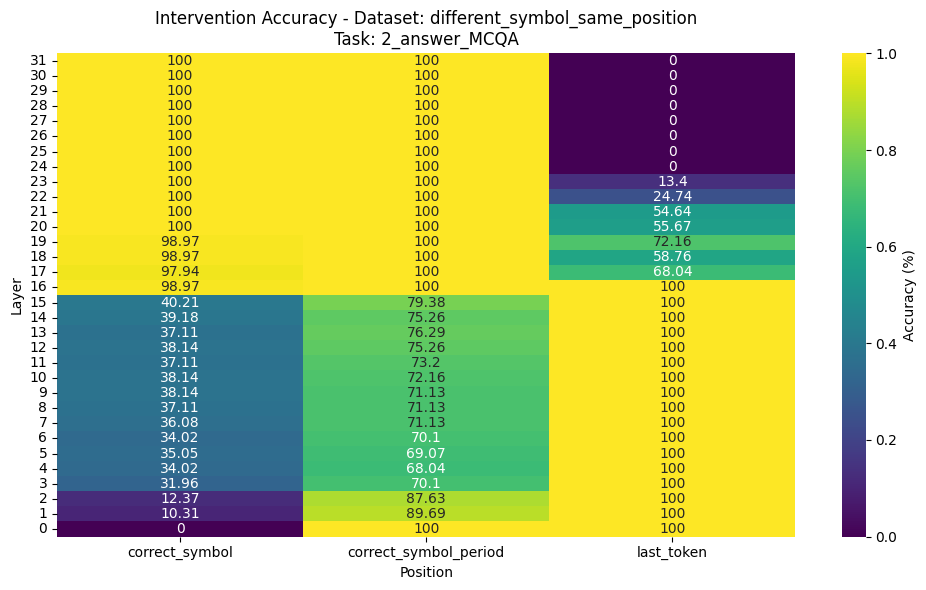

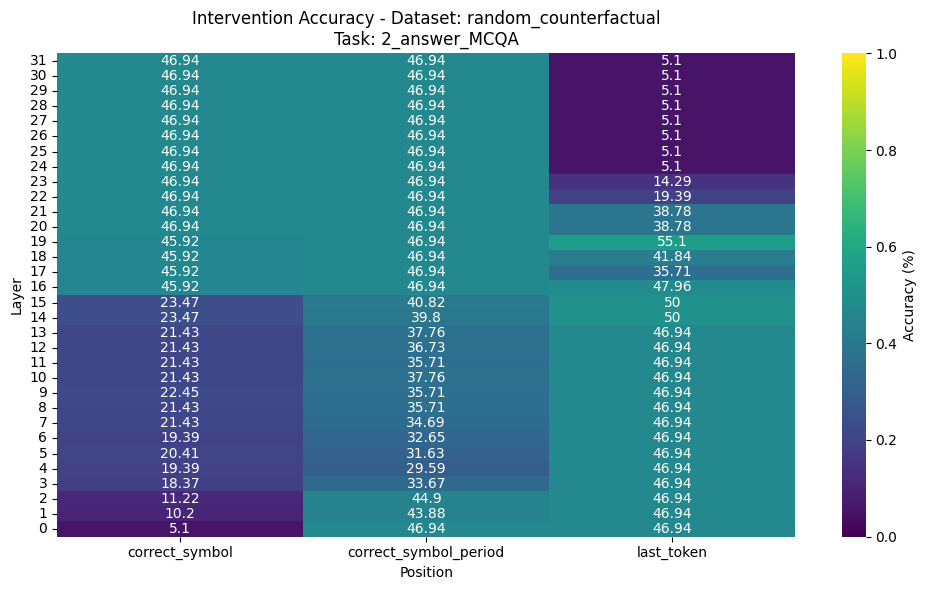

In [17]:
print("\nHeatmaps for 'answer' variable:")
experiment.plot_heatmaps(raw_results, ["answer"])
print("\nHeatmaps for 'answer_position' variable:")
experiment.plot_heatmaps(raw_results, ["answer_position"])

# Train Featurizers with DAS

For each token position and model layer we train a set of 16 orthogonal linear features to realize the answer_position variable in the causal model. 
We again perform interchange interventions on the causal model and the language model, but we will now use the output of the causal model under intervention
as a source of supervision to learn where to intervene in the language model. Instead of intervening on the full 
residual stream vector of the language model, we intervene on a linear subspace that is parameterized using 16 orthogonal vectors. Then we update
these orthogonal vectors such that the output of the LM under interchange intervention is the same as the output of the causal model under interchange intervention.

In [ ]:
config = {
    "batch_size": 16, 
    "evaluation_batch_size": 128, 
    "training_epoch": 8, 
    "n_features": 16, 
}
experiment = PatchResidualStream(pipeline, MCQA_causal_model, list(range(start, end)), token_positions, checker, config=config)
experiment.train_interventions(filtered_datasets, ["answer_position"], method="DAS", verbose=True)
raw_results = experiment.perform_interventions(filtered_datasets, verbose=False, target_variables_list=target_variables_list, save_dir=results_dir)

Model units: [[AtomicModelUnit(id='ResidualStream(Layer-0,Token-correct_symbol)')]]


Epoch: 5:  88%|████████▊ | 22/25 [00:04<00:00,  5.54it/s, loss=3.54, accuracy=0.38, token_accuracy=0.38]

In [ ]:
print("\nHeatmaps for 'answer_position' variable:")
experiment.plot_heatmaps(raw_results, ["answer_position"])